We will load the encoder and visualize the latent space. We want to check if the latent space is well behaved, and is a good input / output space for latent diffusion.

For example, we want to see that frames across time, when encoded, still follow some sort of path in low dimensional projection. 

We could also do latent knn, and check that most of the neighbors for each frame, should be frames that are temporally close to it. 

In [1]:
from functools import partial
import jax
import jax.numpy as jnp
import optax
from models import Encoder, Decoder, Dynamics
from data import make_iterator
from pathlib import Path
from time import time
from utils import pack_mae_params, temporal_patchify, temporal_unpatchify, make_state, make_manager, try_restore, with_params, unpack_mae_params, pack_bottleneck_to_spatial, unpack_spatial_to_bottleneck
import orbax.checkpoint as ocp
from typing import Dict, Any, Tuple
import imageio


In [3]:
def init_models(
    rng: jax.random.PRNGKey,
    encoder: Encoder,
    decoder: Decoder,
    dynamics: Dynamics,
    patch_tokens: jax.Array,
    B: int,
    T: int,
    enc_n_latents: int,
    enc_d_bottleneck: int,
    packing_factor: int,
    num_spatial_tokens: int,
) -> Tuple[jax.random.PRNGKey, Dict[str, Any], Dict[str, Any], Dict[str, Any]]:
    rng, params_rng, mae_rng, dropout_rng = jax.random.split(rng, 4)

    enc_vars = encoder.init(
        {"params": params_rng, "mae": mae_rng, "dropout": dropout_rng},
        patch_tokens, deterministic=True
    )
    fake_enc_z = jnp.ones((B, T, enc_n_latents, enc_d_bottleneck), dtype=jnp.float32)
    fake_packed_z = pack_bottleneck_to_spatial(fake_enc_z, n_s=num_spatial_tokens, k=packing_factor)
    fake_actions = jnp.ones((B, T), dtype=jnp.int32)
    fake_step_idxs = jnp.full((B, T), 0, dtype=jnp.int32)
    fake_signal_idxs = jnp.full((B, T), 0, dtype=jnp.int32)
    dynamics_vars = dynamics.init(
        {"params": params_rng, "dropout": dropout_rng},
        fake_actions,
        fake_step_idxs,
        fake_signal_idxs,
        fake_packed_z,
    )
    dec_vars = decoder.init(
        {"params": params_rng, "dropout": dropout_rng},
        fake_enc_z, deterministic=True
    )
    return rng, enc_vars, dec_vars, dynamics_vars

def _read_only_tokenizer_meta(tokenizer_ckpt_dir: str):
    """Restore just the JSON meta from a tokenizer checkpoint directory."""
    meta_mngr = make_manager(tokenizer_ckpt_dir, item_names=("meta",))
    latest = meta_mngr.latest_step()
    if latest is None:
        raise FileNotFoundError(f"No tokenizer checkpoint found in {tokenizer_ckpt_dir}")
    restored = meta_mngr.restore(latest, args=ocp.args.Composite(meta=ocp.args.JsonRestore()))
    return latest, restored.meta


def load_pretrained_mae_params(
    tokenizer_ckpt_dir: str,
    *,
    rng: jnp.ndarray,
    enc_vars: Dict[str, Any],
    dec_vars: Dict[str, Any],
):
    """Return enc_vars with restored encoder / decoder params from tokenizer ckpt."""
    # -- (A) read meta only with a meta-only manager
    latest, _ = _read_only_tokenizer_meta(tokenizer_ckpt_dir)
    # -- (B) build abstract trees that match the saved structure
    packed_example = pack_mae_params(enc_vars, dec_vars)

    tx_dummy = optax.adamw(1e-4)
    opt_state_example = tx_dummy.init(packed_example)

    state_example = make_state(
        params=packed_example,
        opt_state=opt_state_example,
        rng=rng,
        step=0,
    )
    abstract_state = jax.tree_util.tree_map(ocp.utils.to_shape_dtype_struct, state_example)

    # -- (C) now do a full restore (state + meta) using a manager with both items
    tok_mngr = make_manager(tokenizer_ckpt_dir, item_names=("state", "meta"))
    restored = tok_mngr.restore(
        latest,
        args=ocp.args.Composite(
            state=ocp.args.StandardRestore(abstract_state),
            meta=ocp.args.JsonRestore(),
        )
    )

    packed_params = restored.state["params"]        # {"enc": ..., "dec": ...}
    new_enc_vars, new_dec_vars = unpack_mae_params(packed_params, enc_vars, dec_vars)
    return new_enc_vars, new_dec_vars

def make_dynamics_meta(
    *,
    enc_kwargs: dict,
    dynamics_kwargs: dict,
    H: int, W: int, C: int,
    patch: int,
    k_max: int,
    packing_factor: int,
    n_s: int,
    tokenizer_ckpt_dir: str | None = None,
):
    return {
        "enc_kwargs": enc_kwargs,
        "dynamics_kwargs": dynamics_kwargs,
        "H": H, "W": W, "C": C, "patch": patch,
        "k_max": k_max,
        "packing_factor": packing_factor,
        "n_s": n_s,
        "tokenizer_ckpt_dir": tokenizer_ckpt_dir,
    }

def dynamics_predict_one_step(
    dynamics: Dynamics,
    dynamics_vars: dict,
    z_ctx: jax.Array,            # (B, T_ctx, N_s, D_s)
    actions_ctx: jax.Array,      # (B, T_ctx, D_a)
    actions_curr: jax.Array,     # (B, 1,     D_a)
    batch_size: int,
    ctx_length: int,
    num_sampling_steps: int,
    k_max: int,
    rng: jax.random.PRNGKey,
) -> jax.Array:
    # RNG
    rng, ctx_noise_rng, curr_noise_rng, sampling_rng = jax.random.split(rng, 4)

    # --- Noise using existing tensor shapes (no dynamic ints) ---
    # z_ctx already has the right target shape (B, T_ctx, N_s, D_s)
    z_ctx = z_ctx + 0.1 * jax.random.normal(ctx_noise_rng, z_ctx.shape, dtype=z_ctx.dtype)

    # Fresh slot for current step: use slice shape to avoid ints
    z0 = jax.random.normal(curr_noise_rng, z_ctx[:, :1, :, :].shape, dtype=z_ctx.dtype)
    z_curr = jnp.concatenate([z_ctx, z0], axis=1)  # (B, T_ctx+1, N_s, D_s)

    # Actions concat (shapes are already fixed)
    actions = jnp.concatenate([actions_ctx, actions_curr], axis=1)  # (B, T_ctx+1, D_a)

    # Schedule (constants; shapes depend only on T_total = ctx_length+1 but that’s static per call)
    B = batch_size
    T_total = ctx_length + 1
    d = jnp.reciprocal(jnp.asarray(num_sampling_steps, dtype=jnp.float32))
    step_value = jnp.full((B, T_total), d, dtype=jnp.float32)
    step_idx_scalar = jnp.round(jnp.log2(jnp.asarray(num_sampling_steps, jnp.float32))).astype(jnp.int32)
    step_idx = jnp.full((B, T_total), step_idx_scalar, dtype=jnp.int32)
    signal_value = jnp.zeros((B, T_total), dtype=jnp.float32)
    signal_idx   = jnp.zeros((B, T_total), dtype=jnp.int32)

    def sample_step(carry, n):
        z_curr, signal_idx, signal_value = carry
        drop_rng = jax.random.fold_in(sampling_rng, n)

        flow = dynamics.apply(
            dynamics_vars,
            actions,
            step_idx,
            signal_idx,
            z_curr,
            rngs={"dropout": drop_rng},
            deterministic=True,
        )
        z_curr = z_curr + flow * step_value[..., None, None]
        signal_value = signal_value + step_value
        new_signal_idx = jnp.floor(signal_value * jnp.asarray(k_max, jnp.float32)).astype(jnp.int32)
        new_signal_idx = jnp.clip(new_signal_idx, 0, k_max - 1)
        return (z_curr, new_signal_idx, signal_value), None

    (final_state, _) = jax.lax.scan(
        sample_step,
        (z_curr, signal_idx, signal_value),
        jnp.arange(num_sampling_steps),
    )
    final_z_curr, _, _ = final_state
    return final_z_curr  # (B, T_ctx+1, N_s, D_s)

@partial(
    jax.jit,
    static_argnames=("dynamics","batch_size","ctx_length","num_sampling_steps",
                     "n_s","packing_factor","k_max")
)
def dynamics_predict_multiple_steps(
    dynamics: Dynamics,
    dynamics_vars: dict,
    z_ctx: jax.Array,           # (B, T_ctx, N_s, D_s)
    actions_ctx: jax.Array,     # (B, T_ctx, D_a)
    actions_curr: jax.Array,    # (B, T_pred, D_a)  <-- note T_pred here
    batch_size: int,
    ctx_length: int,
    num_sampling_steps: int,
    n_s: int,
    packing_factor: int,
    k_max: int,
    rng: jax.random.PRNGKey,
) -> jax.Array:
    """
    Returns:
      pred_z_ctx: (B, T_pred, N_s, D_s)  the sequence of predicted frames (no context)
    """
    actions_steps = jnp.swapaxes(actions_curr, 0, 1)[..., None]       # (T_pred, B, 1)
    def _predict_one_step(carry, action_t):  # action_t: (B, 1)
        z_ctx_curr, actions_ctx_curr, rng_curr = carry
        rng_curr, step_rng = jax.random.split(rng_curr)

        # One-step prediction using current context + this step's action
        new_z_ctx = dynamics_predict_one_step(
            dynamics=dynamics,
            dynamics_vars=dynamics_vars,
            z_ctx=z_ctx_curr,
            actions_ctx=actions_ctx_curr,
            actions_curr=action_t,                     # (B, 1, D_a)
            batch_size=batch_size,
            ctx_length=ctx_length,            # use tensor shape, not an int carry
            num_sampling_steps=num_sampling_steps,
            k_max=k_max,
            rng=step_rng,
        )  # (B, T_ctx+1, N_s, D_s)
        # Append new action to action context (shape-stable)
        new_actions_ctx = jnp.concatenate([actions_ctx_curr, action_t], axis=1)  # (B, T_ctx+1, D_a)
        # slice action and z contexts back to ctx_length, keeping the most recent items.
        new_z_ctx = new_z_ctx[:, -ctx_length:, :, :]
        new_actions_ctx = new_actions_ctx[:, -ctx_length:]

        # Last predicted frame for this step (per-step y): (B, N_s, D_s)
        newest_frame = new_z_ctx[:, -1, :, :]

        new_carry = (new_z_ctx, new_actions_ctx, rng_curr)
        return new_carry, newest_frame

    init_carry = (z_ctx, actions_ctx, rng)
    (final_carry, newest_frames) = jax.lax.scan(_predict_one_step, init_carry, actions_steps)
    # newest_frames: (T_pred, B, N_s, D_s) -> (B, T_pred, N_s, D_s)
    pred_z = jnp.swapaxes(newest_frames, 0, 1)
    return pred_z

@partial(
    jax.jit,
    static_argnames=("encoder","decoder","dynamics","batch_size","ctx_length","patch","n_s","packing_factor","num_sampling_steps","k_max")
)
def visualize_dynamics(
    encoder: Encoder,
    decoder: Decoder,
    dynamics: Dynamics,
    enc_vars: dict,
    dec_vars: dict,
    dynamics_vars: dict,
    frames: jax.Array,
    actions: jax.Array,
    batch_size: int,
    ctx_length: int,
    patch: int,
    n_s: int,
    packing_factor: int,
    num_sampling_steps: int,
    k_max: int,
    rng: jax.random.PRNGKey,
):
    """
    Encodes some context frames and actions, predict a sequence of latents, then decode them. 
    Compare it against the actual frames.
    """
    rng, enc_rng, dec_rng, dynamics_rng = jax.random.split(rng, 4)
    # 1) first encode the context frames
    patch_tokens = temporal_patchify(frames, patch)
    enc_z_bottleneck,_ = encoder.apply(enc_vars, patch_tokens, rngs={"mae": enc_rng}, deterministic=True)
    z = pack_bottleneck_to_spatial(enc_z_bottleneck, n_s=n_s, k=packing_factor)
    z_ctx = z[:, :ctx_length, :, :]
    actions_ctx = actions[:, :ctx_length]
    actions_to_predict = actions[:, ctx_length:]
    return z

    # # 2) predict a sequence of latents
    # kwargs = {
    #     "dynamics": dynamics,
    #     "dynamics_vars": dynamics_vars,
    #     "z_ctx": z_ctx,
    #     "actions_ctx": actions_ctx,
    #     "actions_curr": actions_to_predict,
    #     "batch_size": batch_size,
    #     "ctx_length": ctx_length,
    #     "num_sampling_steps": num_sampling_steps,
    #     "n_s": n_s,
    #     "packing_factor": packing_factor,
    #     "k_max": k_max,
    #     "rng": dynamics_rng,
    # }
    # pred_z = dynamics_predict_multiple_steps(**kwargs) # pred z is shape (B, T_pred,...)
    # gt_z = z[:, ctx_length:] # (B, T_pred, ...)
    # combined_z = jnp.concatenate([pred_z, gt_z], axis=0) # combine on batch axis.
    # # decode the predicted latents, and also the true latents
    # combined_z_bottleneck = unpack_spatial_to_bottleneck(combined_z, n_s=n_s, k=packing_factor)
    # combined_z_decoded = decoder.apply(dec_vars, combined_z_bottleneck, rngs={"dropout": dec_rng}, deterministic=True)
    # # split the combined back into pred and gt
    # pred_patches, recon_patches = jnp.split(combined_z_decoded, 2, axis=0)
    # pred_frames = temporal_unpatchify(pred_patches, H, W, C, patch)
    # recon_frames = temporal_unpatchify(recon_patches, H, W, C, patch)
    # return pred_frames, recon_frames
    


In [4]:
log_dir = Path("./logs"); log_dir.mkdir(parents=True, exist_ok=True)
run_name = "test_dynamics"
run_dir = log_dir / run_name; run_dir.mkdir(parents=True, exist_ok=True)

rng = jax.random.PRNGKey(0)
# dataset parameters ...
B, T, H, W, C = 8, 64, 32, 32, 3
B_self = int(0.25 * B)
pixels_per_step = 2 # how many pixels the agent moves per step
size_min = 6 # minimum size of the square
size_max = 14 # maximum size of the square
hold_min = 4 # how long the agent holds a direction for
hold_max = 9 # how long the agent holds a direction for

patch = 4
num_patches = (H // patch) * (W // patch)
D_patch = patch * patch * C
k_max = 256

next_batch = make_iterator(B, T, H, W, C, pixels_per_step, size_min, size_max, hold_min, hold_max)
rng, batch_rng = jax.random.split(rng)
rng, (frames, actions) = next_batch(rng)

# ----- models -----
enc_n_latents, enc_d_bottleneck = 16, 32
enc_kwargs = {
    "d_model": 64, "n_latents": enc_n_latents, "n_patches": num_patches,
    "n_heads": 4, "depth": 8, "dropout": 0.05,
    "d_bottleneck": enc_d_bottleneck, "mae_p_min": 0.0, "mae_p_max": 0.0, "time_every": 4,
}
dec_kwargs = {
    "d_model": 64, "n_heads": 4, "n_patches": num_patches, "n_latents": enc_n_latents, "depth": 8,
    "d_patch": D_patch, "dropout": 0.05, "time_every": 4,
}
packing_factor = 2
n_s = enc_n_latents // packing_factor
dynamics_kwargs = {
    "d_model": 128, "n_s": n_s, "d_spatial": enc_d_bottleneck * packing_factor,
    "d_bottleneck": enc_d_bottleneck, "k_max": k_max, "n_r": 10,
    "n_heads": 4, "depth": 4, "dropout": 0.0
}

encoder = Encoder(**enc_kwargs)
decoder = Decoder(**dec_kwargs)
dynamics = Dynamics(**dynamics_kwargs)

init_patch_tokens = temporal_patchify(frames, patch)
rng, enc_vars, dec_vars, dynamics_vars = init_models(
    rng, encoder, decoder, dynamics, init_patch_tokens, B, T, enc_n_latents, enc_d_bottleneck,
    packing_factor, n_s
)

# ====== (A) load a pretrained encoder / decoder from tokenizer checkpoints ======
TOKENIZER_CKPT_DIR = "/home/edward/projects/tiny_dreamer_4/logs/test/checkpoints" 
if TOKENIZER_CKPT_DIR is not None:
    enc_vars, dec_vars = load_pretrained_mae_params(
        TOKENIZER_CKPT_DIR,
        rng=rng,
        enc_vars=enc_vars,
        dec_vars=dec_vars,
    )
    print(f"[tokenizer] Restored pretrained tokenizer params from: {TOKENIZER_CKPT_DIR}")
# ----- dynamics trainables -----
params = dynamics_vars["params"]
tx = optax.adamw(1e-4)
opt_state = tx.init(params)
max_steps = 1_000_000

# ====== (B) Orbax manager for dynamics run + try to restore ======
ckpt_dir = (run_dir / "checkpoints")
mngr = make_manager(ckpt_dir, max_to_keep=5, save_interval_steps=10_000)

meta = make_dynamics_meta(
    enc_kwargs=enc_kwargs,
    dynamics_kwargs=dynamics_kwargs,
    H=H, W=W, C=C, patch=patch,
    k_max=k_max, packing_factor=packing_factor, n_s=n_s,
    tokenizer_ckpt_dir=TOKENIZER_CKPT_DIR
)

# Build example trees for safe restore
state_example = make_state(params, opt_state, rng, step=0)
restored = try_restore(mngr, state_example, meta)

start_step = 0
if restored is not None:
    latest_step, r = restored
    params     = r.state["params"]
    opt_state  = r.state["opt_state"]
    rng        = r.state["rng"]
    start_step = int(r.state["step"])
    dynamics_vars = with_params(dynamics_vars, params)
    print(f"[dynamics] Restored checkpoint step={latest_step} from {ckpt_dir}")


E1028 18:16:09.065793  575471 buffer_comparator.cc:150] Difference at 3340: inf, expected -2.63427e+38
E1028 18:16:09.065846  575471 buffer_comparator.cc:150] Difference at 3341: inf, expected -2.00435e+38
E1028 18:16:09.065849  575471 buffer_comparator.cc:150] Difference at 3342: inf, expected -2.00397e+38
E1028 18:16:09.065852  575471 buffer_comparator.cc:150] Difference at 3343: inf, expected -3.04785e+38
E1028 18:16:09.065854  575471 buffer_comparator.cc:150] Difference at 3351: inf, expected -1.35449e+37
E1028 18:16:09.065856  575471 buffer_comparator.cc:150] Difference at 3420: inf, expected 4.81067e+37
E1028 18:16:09.065859  575471 buffer_comparator.cc:150] Difference at 3423: inf, expected 6.74815e+36
E1028 18:16:09.065862  575471 buffer_comparator.cc:150] Difference at 3572: -inf, expected -3.23577e+38
E1028 18:16:09.065865  575471 buffer_comparator.cc:150] Difference at 3573: -inf, expected -1.48538e+38
E1028 18:16:09.065868  575471 buffer_comparator.cc:150] Difference at 357

[tokenizer] Restored pretrained tokenizer params from: /home/edward/projects/tiny_dreamer_4/logs/test/checkpoints
[dynamics] Restored checkpoint step=0 from logs/test_dynamics/checkpoints


In [7]:
from jax._src.interpreters.batching import zero_if_mapped


data_rng = jax.random.PRNGKey(0)
_, (frames, actions) = next_batch(data_rng)
ctx_length = 63
num_sampling_steps = 32
visualize_dynamics_kwargs = {
    "encoder": encoder,
    "decoder": decoder,
    "dynamics": dynamics,
    "enc_vars": enc_vars,
    "dec_vars": dec_vars,
    "dynamics_vars": dynamics_vars,
    "frames": frames,
    "actions": actions,
    "batch_size": B,
    "ctx_length": ctx_length,
    "patch": patch,
    "n_s": n_s,
    "packing_factor": packing_factor,
    "num_sampling_steps": num_sampling_steps,
    "k_max": k_max,
    "rng": rng,
}
start = time()
z = visualize_dynamics(**visualize_dynamics_kwargs)
visualize_time = time() - start
print(f"Visualization time: {visualize_time:.3f} seconds")

Visualization time: 0.002 seconds


In [ ]:
z.shape # (B, T, N_s, D_s )
z_bottleneck = unpack_spatial_to_bottleneck(z, n_s=n_s, k=packing_factor) # (B, T, N_z, D_z)
print(z_bottleneck.shape) # (8, 64, 16, 32)

(8, 64, 16, 32)


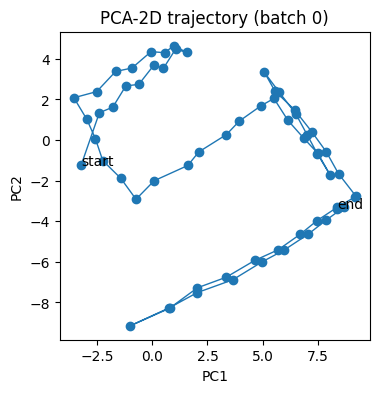

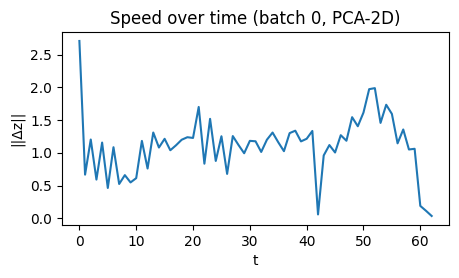

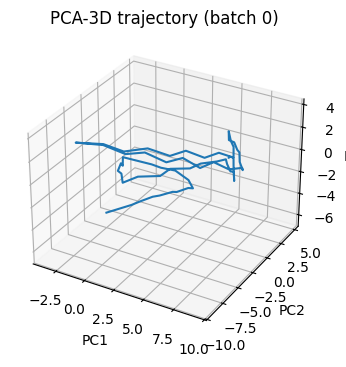

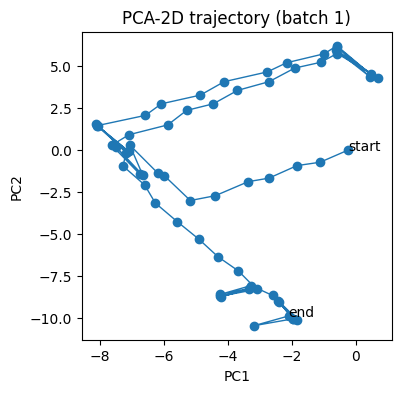

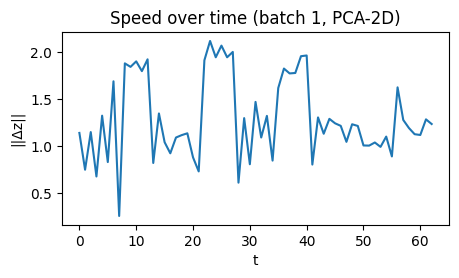

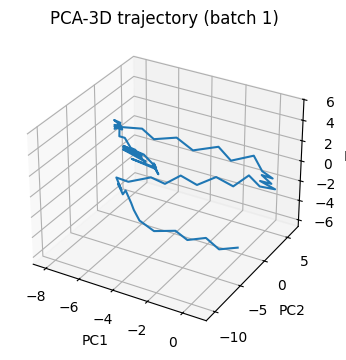

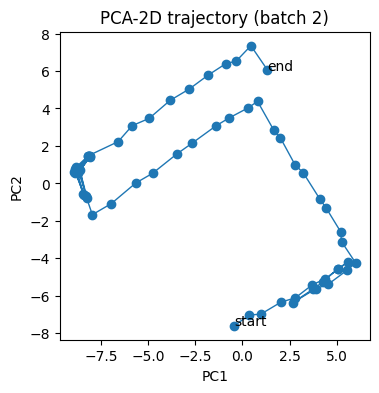

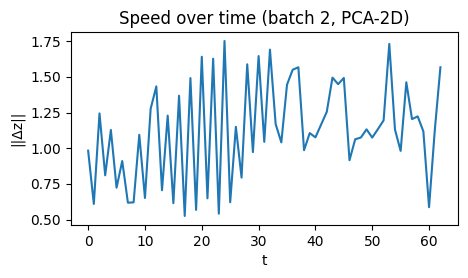

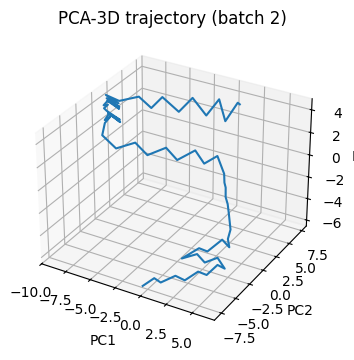

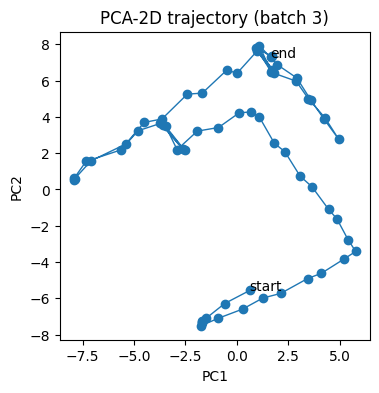

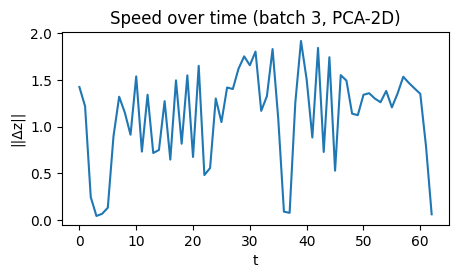

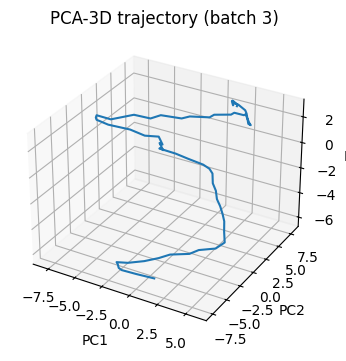

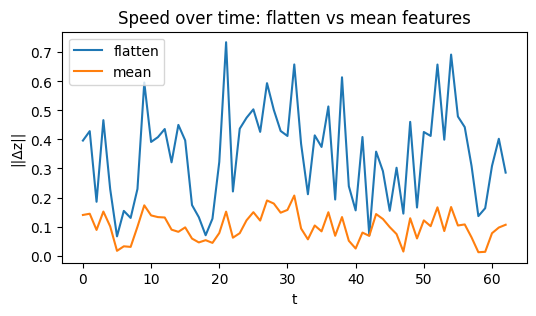

Top-10 explained variance ratios: [0.27407166 0.24974988 0.16803764 0.06528565 0.04081409 0.03638813
 0.02688499 0.02207059 0.01737066 0.0159418 ]


: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# ---- prerequisites: z_bottleneck is a JAX array of shape (B, T, 16, 32) ----

def make_per_timestep_features(z_btlD, mode="flatten"):
    """
    z_btlD: (B, T, N_latents, D_latent)
    mode:   "flatten"  -> feature_t = concat(latents)   shape D = N_latents * D_latent
            "mean"     -> feature_t = mean over latents shape D = D_latent
    returns: feats (B, T, D_feat)
    """
    if mode == "flatten":
        feats = z_btlD.reshape(z_btlD.shape[0], z_btlD.shape[1], -1)
    elif mode == "mean":
        feats = z_btlD.mean(axis=2)  # (B, T, D_latent)
    else:
        raise ValueError("mode must be 'flatten' or 'mean'")
    return feats

def pca_fit_transform(X, n_components=2, center=True, whiten=False):
    """
    X: (N, D) array (NumPy or JAX ok); returns (Z, pca_dict)
    PCA via SVD on the centered data. whiten scales by singular values.
    """
    X = np.asarray(X)  # work in NumPy for plotting convenience
    mu = X.mean(axis=0) if center else np.zeros(X.shape[1], dtype=X.dtype)
    Xc = X - mu
    # economy SVD
    U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
    W = Vt[:n_components]                       # (k, D)
    Z = Xc @ W.T                                # (N, k)
    if whiten:
        eps = 1e-8
        Z = Z / (S[:n_components] + eps)        # optional whitening
    pca = {"mean": mu, "components": W, "singular_values": S, "explained_var": (S**2)/(X.shape[0]-1)}
    return Z, pca

def project_sequences(feats_btD, n_components=2, center=True, whiten=False):
    """
    feats_btD: (B, T, D)
    returns:
      Z_bt2: (B, T, n_components)
      pca   dict with components, mean, etc.
    """
    B, T, D = feats_btD.shape
    X = feats_btD.reshape(B*T, D)
    Z, pca = pca_fit_transform(X, n_components=n_components, center=center, whiten=whiten)
    return Z.reshape(B, T, n_components), pca

def speeds_and_accels(feats):
    """
    feats: either (B, T, D) or (T, D)
    returns:
      speed:  (B, T-1) or (T-1,)
      accel:  (B, T-2) or (T-2,)
    """
    X = np.asarray(feats)
    if X.ndim == 2:  # (T, D)
        if X.shape[0] < 2:
            return np.array([]), np.array([])
        diffs = X[1:] - X[:-1]                  # (T-1, D)
        speed = np.linalg.norm(diffs, axis=-1)  # (T-1,)
        accel = np.linalg.norm(diffs[1:] - diffs[:-1], axis=-1) if diffs.shape[0] >= 2 else np.array([])
        return speed, accel
    elif X.ndim == 3:  # (B, T, D)
        if X.shape[1] < 2:
            return np.array([]), np.array([])
        diffs = X[:, 1:, :] - X[:, :-1, :]                  # (B, T-1, D)
        speed = np.linalg.norm(diffs, axis=-1)              # (B, T-1)
        accel = np.linalg.norm(diffs[:, 1:, :] - diffs[:, :-1, :], axis=-1) if diffs.shape[1] >= 2 else np.array([])
        return speed, accel
    else:
        raise ValueError("feats must be (T,D) or (B,T,D)")


# ---------------- main checks ----------------
# 1) choose how to build a per-timestep feature
feats_btD_flat   = np.asarray(make_per_timestep_features(z_bottleneck, mode="flatten"))  # (B,T,512)
feats_btD_mean   = np.asarray(make_per_timestep_features(z_bottleneck, mode="mean"))     # (B,T,32)

# 2) PCA on the flattened representation (stronger signal usually)
Z2_bt2, pca2 = project_sequences(feats_btD_flat, n_components=2, center=True, whiten=False)
Z3_bt3, _    = project_sequences(feats_btD_flat, n_components=3, center=True, whiten=False)

# 3) plot 2D and 3D trajectories for a few sequences
max_show = min(4, Z2_bt2.shape[0])
for b in range(max_show):
    # 2D trajectory
    plt.figure(figsize=(4,4))
    plt.plot(Z2_bt2[b, :, 0], Z2_bt2[b, :, 1], marker='o', linewidth=1)
    plt.title(f"PCA-2D trajectory (batch {b})")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    # annotate start/end
    plt.annotate("start", (Z2_bt2[b,0,0], Z2_bt2[b,0,1]))
    plt.annotate("end",   (Z2_bt2[b,-1,0], Z2_bt2[b,-1,1]))
    plt.show()

    # Speeds/accels in PCA space (sanity for smoothness)
    sp, ac = speeds_and_accels(Z2_bt2[b])
    plt.figure(figsize=(5,2.5))
    plt.plot(sp)
    plt.title(f"Speed over time (batch {b}, PCA-2D)")
    plt.xlabel("t"); plt.ylabel("||Δz||")
    plt.show()

    if Z3_bt3.shape[-1] == 3:
        from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D proj)
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(Z3_bt3[b, :, 0], Z3_bt3[b, :, 1], Z3_bt3[b, :, 2])
        ax.set_title(f"PCA-3D trajectory (batch {b})")
        ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
        plt.show()

# 4) optional: compare “flatten” vs “mean” features’ smoothness
sp_flat, ac_flat = speeds_and_accels(Z2_bt2.mean(axis=0, keepdims=False)[None, ...])  # aggregated
Z2m_bt2, _ = project_sequences(feats_btD_mean, n_components=2)
sp_mean, ac_mean = speeds_and_accels(Z2m_bt2.mean(axis=0, keepdims=False)[None, ...])

plt.figure(figsize=(6,3))
plt.plot(sp_flat[0], label="flatten")
plt.plot(sp_mean[0], label="mean")
plt.title("Speed over time: flatten vs mean features")
plt.xlabel("t"); plt.ylabel("||Δz||")
plt.legend()
plt.show()

# 5) print a quick PCA spectrum to spot collapse/anisotropy
ev = pca2["explained_var"]
ratio = ev[:10] / ev.sum()
print("Top-10 explained variance ratios:", ratio)
